In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, loss_l1=F.l1_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_l1 = loss_l1
        self.loss_fn = loss_fn
        self._loss_l1 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
#         self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def lossl1(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss_l1 = self.loss_l1(x, target, **kwargs)
        return self._loss_l1        
    
#     def rho_loss(self, rho, log_rho=None, size_average=True):
#         """
#         D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
#         """
#         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)

#         if size_average:
#             self._rho_loss = dkl.mean()
#         else:
#             self._rho_loss = dkl.sum()
#         return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
# rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)            
#             rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + model.lossl1(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
#     else:
#         batch_idx += 1
#         line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
#             epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
#         losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
#         if log is not None:
#             for k in models:
#                 log[k].append((models[k]._loss, models[k]._rho_loss))
#         print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
l1_lambda = lambda p: 'l1_loss: {:.4f}'.format(p)
line = lambda i, l, p : '{}: '.format(i) + avg_lambda(l)  + '\t'  + l1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    l1_test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                l1_test_loss[k] += m.lossl1(output[k], data, reduction='sum').item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        l1_test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append((test_loss[k], l1_test_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], l1_test_loss[k]) for k in models]) + '\n' 
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.989456 32: 1.016289 64: 0.988640
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.689461 32: 0.466489 64: 0.315854
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.460871 32: 0.310712 64: 0.268737
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.359934 32: 0.285090 64: 0.262282
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.309581 32: 0.269236 64: 0.245017
Test set:
16: loss: 0.2941	l1_loss: 0.3805
32: loss: 0.2705	l1_loss: 0.3132
64: loss: 0.2413	l1_loss: 0.2713

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.288986 32: 0.265392 64: 0.235085
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.311441 32: 0.294191 64: 0.255827
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.268534 32: 0.253720 64: 0.210533
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.285419 32: 0.268233 64: 0.215400
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.265802 32: 0.249717 64: 0.192602
Test set:
16: loss: 0.2734	l1_loss: 0.3090
32: loss: 0.2510	l1_loss: 0.2726
64: loss: 0.18

Train Epoch: 17 [10000/50000 (20%)]	Losses 16: 0.129899 32: 0.076267 64: 0.039607
Train Epoch: 17 [20000/50000 (40%)]	Losses 16: 0.116462 32: 0.071197 64: 0.034160
Train Epoch: 17 [30000/50000 (60%)]	Losses 16: 0.114380 32: 0.067088 64: 0.034779
Train Epoch: 17 [40000/50000 (80%)]	Losses 16: 0.121152 32: 0.069809 64: 0.035446
Test set:
16: loss: 0.1239	l1_loss: 0.1557
32: loss: 0.0724	l1_loss: 0.1071
64: loss: 0.0363	l1_loss: 0.0668

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.122469 32: 0.070173 64: 0.034076
Train Epoch: 18 [10000/50000 (20%)]	Losses 16: 0.122339 32: 0.068669 64: 0.034046
Train Epoch: 18 [20000/50000 (40%)]	Losses 16: 0.108721 32: 0.058559 64: 0.026653
Train Epoch: 18 [30000/50000 (60%)]	Losses 16: 0.118816 32: 0.067429 64: 0.035299
Train Epoch: 18 [40000/50000 (80%)]	Losses 16: 0.117642 32: 0.069645 64: 0.035690
Test set:
16: loss: 0.1210	l1_loss: 0.1519
32: loss: 0.0696	l1_loss: 0.1039
64: loss: 0.0350	l1_loss: 0.0646

Train Epoch: 19 [0/50000 (0%)]	Losses 16: 0.118

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded >= 0.).sum(1))
    print((encoded >=0.99).sum(1))
    print((encoded < 0.01).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([31, 25, 24, 34, 29, 27, 34, 31, 28, 27, 34, 31, 27, 32, 28, 27, 28, 33,
        26, 24, 22, 28, 27, 28, 27, 37, 24, 32, 31, 32, 30, 28, 33, 30, 26, 32,
        32, 31, 30, 30, 27, 27, 28, 28, 20, 26, 29, 26, 36, 29])
tensor([2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 3, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 4, 4, 1, 2, 2, 3, 1, 1, 1, 2, 2, 1, 1,
        2, 2])
tensor([33, 39, 40, 30, 35, 37, 30, 33, 36, 37, 30, 33, 38, 32, 36, 37, 36, 31,
        38, 40, 42, 36, 38, 36, 37, 27, 40, 32, 33, 32, 35, 36, 31, 34, 38, 33,
        32, 33, 36, 34, 37, 37, 36, 36, 44, 38, 36, 38, 29, 35])


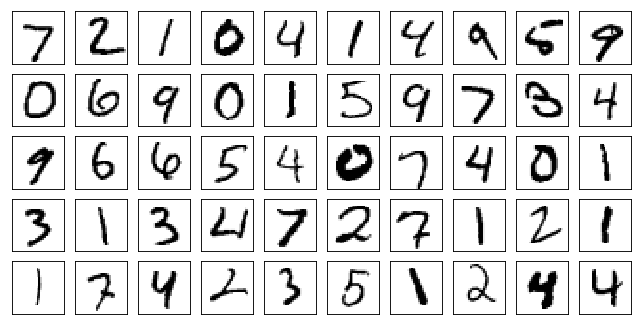

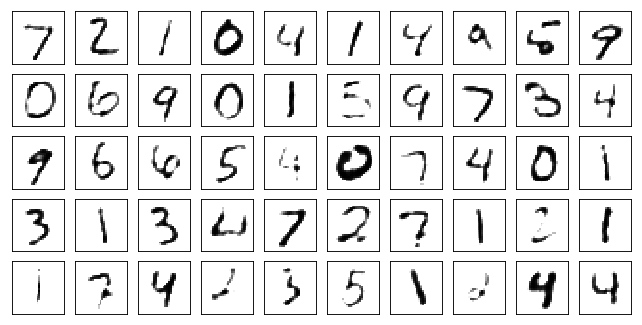

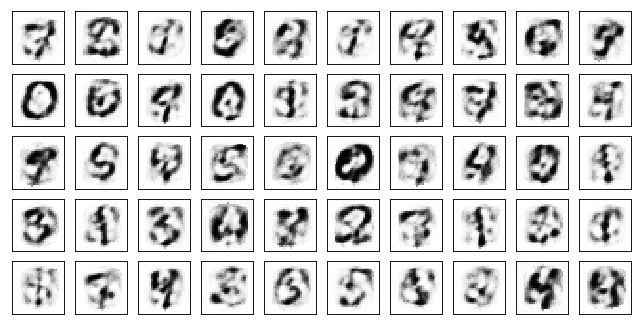

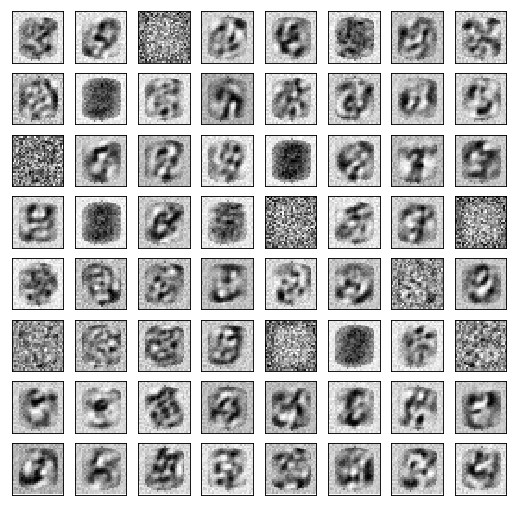

In [10]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))